🔁 Calculando distancias DTW...
🌳 Realizando clustering jerárquico...


C:\Users\waldo\AppData\Local\Temp\ipykernel_15716\3574682890.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method="average")


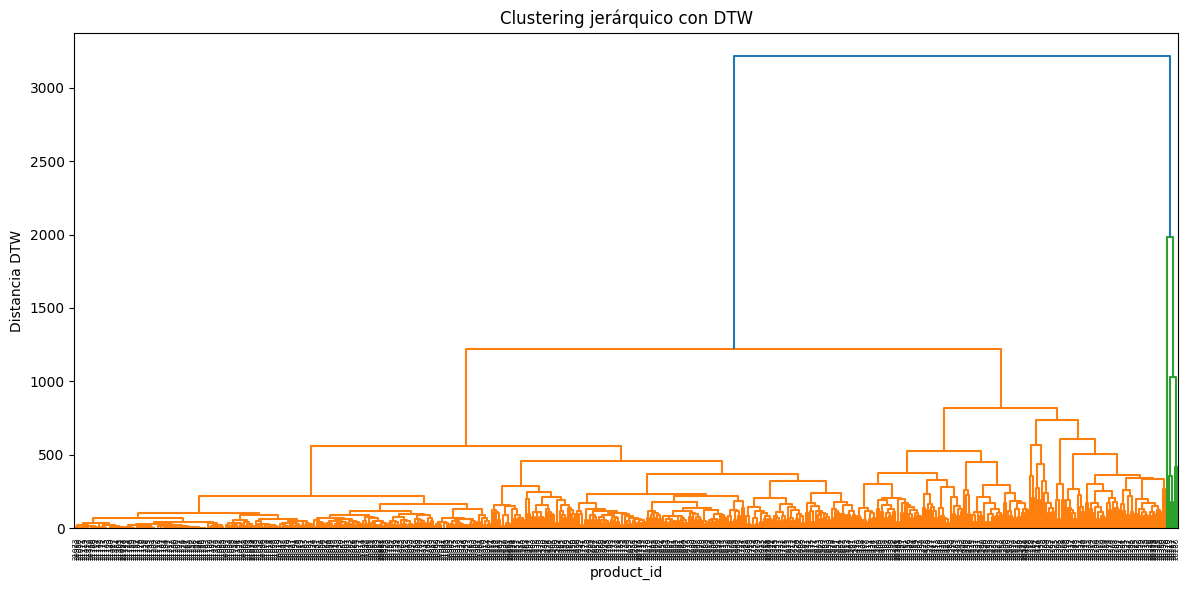

cluster
1    550
2      5
3      1
Name: count, dtype: int64
✅ Guardado 'clusters_dtw_top10.csv'


In [10]:
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_dtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# === 1. Cargar dataset ===
df = pd.read_csv("top_10_corr.csv")
df["periodo"] = pd.to_datetime(df["periodo"])

# === 2. Pivotear con agregación: cada fila es un producto, cada columna un mes ===
serie = df.pivot_table(index="product_id", columns="periodo", values="tn", aggfunc='sum').fillna(0)
series = serie.values

# === 3. Calcular matriz de distancias DTW ===
print("🔁 Calculando distancias DTW...")
dist_matrix = cdist_dtw(series)

# === 4. Clustering jerárquico ===
print("🌳 Realizando clustering jerárquico...")
linkage_matrix = linkage(dist_matrix, method="average")

# === 5. Dendrograma ===
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=serie.index.astype(str).tolist())
plt.title("Clustering jerárquico con DTW")
plt.xlabel("product_id")
plt.ylabel("Distancia DTW")
plt.tight_layout()
plt.show()

# === 6. Asignar clusters ===
n_clusters = 3
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
df_clusters = pd.DataFrame({
    "product_id": serie.index,
    "cluster": clusters
})
print(df_clusters.value_counts("cluster"))

# === 7. Guardar asignación de clusters ===
df_clusters.to_csv("clusters_dtw_top10.csv", index=False)
print("✅ Guardado 'clusters_dtw_top10.csv'")


In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# === 1. Cargar datasets ===
#df = pd.read_csv("top_10_corr.csv", parse_dates=["periodo"])
clusters = pd.read_csv("clusters_dtw_top10.csv")

# === 2. Unir clusters y preparar datos ===
df["product_id"] = df["product_id"].astype(str)
clusters["product_id"] = clusters["product_id"].astype(str)
df = df.merge(clusters, on="product_id", how="left")

# === 3. Crear columna 'mes' como variable numérica para regresión ===
df["mes"] = (df["periodo"] - pd.to_datetime("2017-03-01")).dt.days // 30  # convierte a meses desde inicio

# === 4. Entrenar modelo por cluster y predecir febrero 2020 ===
predicciones = []

for cluster in sorted(df["cluster"].unique()):
    df_cluster = df[df["cluster"] == cluster].copy()

    for product_id in df_cluster["product_id"].unique():
        serie = df_cluster[df_cluster["product_id"] == product_id].copy()
        serie = serie.sort_values("periodo")

        # Filtrar hasta enero 2020
        serie_train = serie[serie["periodo"] <= "2020-01-01"]

        X_train = serie_train[["mes"]].values
        y_train = serie_train["tn"].values

        if len(X_train) < 2:
            # Si hay muy pocos datos, repetir valor de enero
            valor_enero = serie_train[serie_train["periodo"] == "2020-01-01"]["tn"].values
            if len(valor_enero) == 0:
                continue
            predicciones.append((product_id, valor_enero[0]))
            continue

        modelo = LinearRegression()
        modelo.fit(X_train, y_train)

        # Febrero 2020 → mes = 35
        mes_febrero = np.array([[35]])
        pred = modelo.predict(mes_febrero)[0]

        pred = max(pred, 0)  # No permitir valores negativos
        predicciones.append((product_id, pred))

# === 5. Exportar resultado ===
df_pred = pd.DataFrame(predicciones, columns=["product_id", "tn_predicho"])
df_pred.to_csv("prediccion_feb2020_top10_dtw_regresion.csv", index=False)

print("✅ Archivo generado: prediccion_feb2020_top10_dtw_regresion.csv")
print(f"📦 Productos predichos: {len(df_pred)}")
print(f"🔢 Total tn predichas: {df_pred['tn_predicho'].sum():,.2f}")


✅ Archivo generado: prediccion_feb2020_top10_dtw_regresion.csv
📦 Productos predichos: 556
🔢 Total tn predichas: 13.17


In [13]:
import pandas as pd

# === 1. Cargar dataset ===
#df = pd.read_csv("top_10_corr.csv")
df["periodo"] = pd.to_datetime(df["periodo"])

# === 2. Agrupar por período y sumar las toneladas ===
df_total_por_periodo = df.groupby("periodo")["tn"].sum().reset_index()

# === 3. Mostrar resultado ===
print(df_total_por_periodo)

# === 4. (Opcional) Exportar a CSV ===
#df_total_por_periodo.to_csv("total_tn_por_periodo_top10.csv", index=False)
print("✅ Exportado como 'total_tn_por_periodo_top10.csv'")


      periodo          tn
0  2017-01-01  2240.76572
1  2017-02-01  2345.42280
2  2017-03-01  3028.43438
3  2017-04-01  2553.14995
4  2017-05-01  3052.17630
5  2017-06-01  2964.36973
6  2017-07-01  2304.37712
7  2017-08-01  2335.19581
8  2017-09-01  2576.91927
9  2017-10-01  3048.05447
10 2017-11-01  2942.11283
11 2017-12-01  2613.70719
12 2018-01-01  2604.28654
13 2018-02-01  2780.20890
14 2018-03-01  3975.89307
15 2018-04-01  3381.34861
16 2018-05-01  3555.86976
17 2018-06-01  3214.20957
18 2018-07-01  3014.80621
19 2018-08-01  3036.27301
20 2018-09-01  2701.47514
21 2018-10-01  2856.38007
22 2018-11-01  2630.07727
23 2018-12-01  2455.27666
24 2019-01-01  2621.34258
25 2019-02-01  2879.03817
26 2019-03-01  3800.27881
27 2019-04-01  3430.86905
28 2019-05-01  3911.91116
29 2019-06-01  4106.02435
30 2019-07-01  4339.28222
31 2019-08-01  3393.90538
32 2019-09-01  4208.80163
33 2019-10-01  4651.28789
34 2019-11-01  4054.04955
35 2019-12-01  3242.00241
✅ Exportado como 'total_tn_por_periodo

In [14]:
import pandas as pd

# === 1. Cargar archivos ===
df_real = pd.read_csv("top_10_corr.csv", parse_dates=["periodo"])
df_pred = pd.read_csv("prediccion_feb2020_top10_dtw_regresion.csv")

# === 2. Filtrar febrero 2020 y diciembre 2019 ===
febrero_2020 = pd.Timestamp("2020-02-01")
diciembre_2019 = pd.Timestamp("2019-12-01")

real_feb = df_real[df_real["periodo"] == febrero_2020]
real_dic = df_real[df_real["periodo"] == diciembre_2019]

# === 3. Agrupar por product_id y sumar tn ===
tn_real_feb = real_feb.groupby("product_id")["tn"].sum().reset_index()
tn_real_dic = real_dic.groupby("product_id")["tn"].sum().reset_index()
tn_real_feb.rename(columns={"tn": "tn_real_feb"}, inplace=True)
tn_real_dic.rename(columns={"tn": "tn_real_dic"}, inplace=True)

# === 4. Unir con predicción ===
df_pred["product_id"] = df_pred["product_id"].astype(str)
tn_real_feb["product_id"] = tn_real_feb["product_id"].astype(str)
tn_real_dic["product_id"] = tn_real_dic["product_id"].astype(str)

df_merge = df_pred.merge(tn_real_feb, on="product_id", how="left")
df_merge = df_merge.merge(tn_real_dic, on="product_id", how="left")

# === 5. Sumas totales ===
total_pred = df_merge["tn_predicho"].sum()
total_real_feb = df_merge["tn_real_feb"].sum()
total_real_dic = df_merge["tn_real_dic"].sum()

print(f"📦 Total predicho febrero 2020: {total_pred:.2f} tn")
print(f"📊 Total real febrero 2020: {total_real_feb:.2f} tn")
print(f"📆 Total real diciembre 2019: {total_real_dic:.2f} tn")

# === 6. Exportar para análisis detallado ===
df_merge.to_csv("comparacion_real_vs_pred_top10.csv", index=False)
print("✅ Archivo exportado: comparacion_real_vs_pred_top10.csv")


📦 Total predicho febrero 2020: 13.17 tn
📊 Total real febrero 2020: 0.00 tn
📆 Total real diciembre 2019: 3242.00 tn
✅ Archivo exportado: comparacion_real_vs_pred_top10.csv


In [7]:
df_real

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,...,is_max_3,is_max_6,is_max_12,is_max_24,is_max_36,año,mes,cuatrimestre,mes_absoluto,cos_mes
0,10032,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
1,10035,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
2,10036,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
3,10037,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
4,10152,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259351,10159,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,0,0,0,0,0,2019,12,3,35,1.000000
6259352,10101,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
6259353,10154,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
6259354,10052,21276,2019-12-01,0.0,1.0,0.00594,0.00594,1.05592,2,6,...,1,1,1,0,0,2019,12,3,35,1.000000


In [8]:
dfbase=pd.read_csv("dataset_base_features.csv")

In [9]:
dfbase

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,...,is_max_3,is_max_6,is_max_12,is_max_24,is_max_36,año,mes,cuatrimestre,mes_absoluto,cos_mes
0,10004,20001,2017-01-01,0.0,9.0,184.72927,184.72927,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
1,10003,20001,2017-01-01,0.0,17.0,143.49426,143.49426,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
2,10002,20001,2017-01-01,0.0,17.0,38.68301,35.72806,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
3,10001,20001,2017-01-01,0.0,11.0,99.43861,99.43861,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
4,10084,20001,2017-01-01,0.0,1.0,0.22386,0.22386,0.00000,1,10,...,0,0,0,0,0,2017,1,1,0,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460975,10159,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,0,0,0,0,0,2019,12,3,35,1.000000
9460976,10101,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
9460977,10154,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
9460978,10052,21276,2019-12-01,0.0,1.0,0.00594,0.00594,1.05592,2,6,...,1,1,1,0,0,2019,12,3,35,1.000000


In [16]:
import pandas as pd

# === 1. Cargar dataset base ===
df = pd.read_csv("top_10_corr.csv")
df["periodo"] = pd.to_datetime(df["periodo"])
df["product_id"] = df["product_id"].astype(str)

# === 2. Filtrar febrero de 2017, 2018, 2019 ===
febreros = df[df["periodo"].dt.month == 2]
febreros = febreros[febreros["periodo"].dt.year.isin([2017, 2018, 2019])]
prom_feb = febreros.groupby("product_id")["tn"].mean().reset_index()
prom_feb.rename(columns={"tn": "prom_feb"}, inplace=True)

# === 3. Calcular media móvil 12 meses hasta 2019-12 ===
ultimos_12 = df[(df["periodo"] >= "2019-01-01") & (df["periodo"] <= "2019-12-31")]
media_movil = ultimos_12.groupby("product_id")["tn"].mean().reset_index()
media_movil.rename(columns={"tn": "media_12m"}, inplace=True)

# === 4. Unir y calcular predicción ===
pred = prom_feb.merge(media_movil, on="product_id", how="outer").fillna(0)
pred["tn_predicha"] = 0.8 * pred["prom_feb"] + 0.2 * pred["media_12m"]

# === 5. Guardar predicción febrero 2020 ===
df_pred = pred[["product_id", "tn_predicha"]]
df_pred.to_csv("prediccion_febrero_2020_top10_prom80movavg20.csv", index=False)
print("✅ Exportado: prediccion_febrero_2020_top10_prom80movavg20.csv")
print(f"🔢 Total tn predichas: {df_pred['tn_predicha'].sum():,.2f}")


✅ Exportado: prediccion_febrero_2020_top10_prom80movavg20.csv
🔢 Total tn predichas: 8.60


In [17]:
import pandas as pd

# === 1. Cargar dataset ===

df["periodo"] = pd.to_datetime(df["periodo"])

# === 2. Filtrar registros de febrero ===
df_feb = df[df["periodo"].dt.month == 2]

# === 3. Agrupar por año y sumar tn ===
suma_febrero = df_feb.groupby(df_feb["periodo"].dt.year)["tn"].sum().reset_index()
suma_febrero.columns = ["año", "total_tn_febrero"]

# === 4. Mostrar resultado y exportar si querés ===
print(suma_febrero)




    año  total_tn_febrero
0  2017        2345.42280
1  2018        2780.20890
2  2019        2879.03817


In [19]:
import pandas as pd


df["periodo"] = pd.to_datetime(df["periodo"])

# === 2. Filtrar febrero de 2017, 2018 y 2019 ===
df_feb = df[
    (df["periodo"].dt.month == 2) &
    (df["periodo"].dt.year.isin([2017, 2018, 2019]))
]

# === 3. Calcular promedio de tn por product_id ===
promedio_feb = df_feb.groupby("product_id")["tn"].mean().reset_index()
promedio_feb.columns = ["product_id", "tn_prom_feb_17_18_19"]

# === 4. Mostrar resultado y exportar ===
print(promedio_feb.head(50))




   product_id  tn_prom_feb_17_18_19
0       20210              0.000000
1       20213              0.000000
2       20218              0.093041
3       20236              0.000000
4       20257              0.000000
5       20261              0.000000
6       20262              0.098471
7       20266              0.029150
8       20275              0.053016
9       20276              0.045394
10      20278              0.115907
11      20281              0.062645
12      20285              0.078973
13      20286              0.000000
14      20288              0.062470
15      20290              0.026567
16      20291              0.063585
17      20292              0.033639
18      20295              0.056631
19      20296              0.046674
20      20297              0.023284
21      20298              0.017607
22      20300              0.035677
23      20301              0.035905
24      20302              0.045203
25      20303              0.036470
26      20304              0

In [20]:
df

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,...,is_max_3,is_max_6,is_max_12,is_max_24,is_max_36,año,mes,cuatrimestre,mes_absoluto,cos_mes
0,10032,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
1,10035,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
2,10036,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
3,10037,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
4,10152,20210,2017-01-01,0.0,0.0,0.00000,0.00000,0.00000,1,10,...,1,1,1,1,1,2017,1,1,0,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259351,10159,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,0,0,0,0,0,2019,12,3,35,1.000000
6259352,10101,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
6259353,10154,21276,2019-12-01,0.0,0.0,0.00000,0.00000,1.05592,2,6,...,1,0,0,0,0,2019,12,3,35,1.000000
6259354,10052,21276,2019-12-01,0.0,1.0,0.00594,0.00594,1.05592,2,6,...,1,1,1,0,0,2019,12,3,35,1.000000


In [22]:

df["periodo"] = pd.to_datetime(df["periodo"])
df["product_id"] = df["product_id"].astype(str)

# 2. Ordenar
df = df.sort_values(["product_id", "periodo"])

# 3. Calcular media móvil de 12 meses
df["tn_ma12"] = df.groupby("product_id")["tn"].transform(lambda x: x.rolling(12, min_periods=1).mean())

# 4. Filtrar diciembre 2019
ma12_dic2019 = df[df["periodo"] == "2019-12-01"][["product_id", "tn_ma12"]].copy()

# 5. Mostrar
print(ma12_dic2019.head())
print(f"✅ Total de product_id en diciembre 2019 con media móvil: {ma12_dic2019.shape[0]}")


     product_id   tn_ma12
6020      20210  0.018673
6021      20210  0.018673
6022      20210  0.018673
6023      20210  0.018673
6024      20210  0.009710
✅ Total de product_id en diciembre 2019 con media móvil: 173871


In [25]:
# 1. Asegurarse que ambos tienen 'product_id' como string
promedio_feb["product_id"] = promedio_feb["product_id"].astype(str)
ma12_dic2019["product_id"] = ma12_dic2019["product_id"].astype(str)

# 2. Merge por product_id
df_pred = pd.merge(promedio_feb, ma12_dic2019, on="product_id", how="inner")

# 3. Combinación ponderada
df_pred["tn_predicho"] = (df_pred["tn_prom_feb_17_18_19"] * 0.8) + (df_pred["tn_ma12"] * 0.2)

# 4. Dejar solo columnas necesarias para Kaggle
df_final = df_pred[["product_id", "tn_predicho"]]

# 5. Exportar
df_final.to_csv("prediccion_feb2020_prom80_ma20.csv", index=False)
print("✅ Predicción exportada como 'prediccion_feb2020_prom80_ma20.csv'")
print(f"🔢 Total product_id: {df_final.shape[0]}")


✅ Predicción exportada como 'prediccion_feb2020_prom80_ma20.csv'
🔢 Total product_id: 173871


In [26]:
import pandas as pd

# Cargar predicción
df_pred = pd.read_csv("prediccion_feb2020_prom80_ma20.csv")

# Mostrar los primeros valores ordenados por tn_predicho
print(df_pred.sort_values("tn_predicho", ascending=False).head(20))

# Estadísticas generales
print("\n📊 Estadísticas:")
print(df_pred["tn_predicho"].describe())

# Suma total
print(f"\n🔢 Suma total de tn predichas: {df_pred['tn_predicho'].sum():,.2f} tn")


      product_id  tn_predicho
52         20210     0.560368
53         20210     0.559621
57         20210     0.553496
56         20210     0.546923
55         20210     0.533179
54         20210     0.533179
58         20210     0.490751
60         20210     0.469239
1619       20262     0.469167
1620       20262     0.469167
1621       20262     0.469167
1622       20262     0.469167
1618       20262     0.467966
1617       20262     0.467966
59         20210     0.465654
1616       20262     0.440939
1760       20266     0.437234
1759       20266     0.433594
1758       20266     0.429044
1762       20266     0.424721

📊 Estadísticas:
count    173871.000000
mean          0.016047
std           0.021111
min           0.000000
25%           0.003441
50%           0.009875
75%           0.023273
max           0.560368
Name: tn_predicho, dtype: float64

🔢 Suma total de tn predichas: 2,790.16 tn
